In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import yaml
%pip install ultralytics
import ultralytics



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.2/699.2 kB 7.6 MB/s eta 0:00:00


In [2]:
np.random.seed(42)

# Set the path to the dataset
dataset_path = '.'

# Set the paths to images and annotations
images_folder = os.path.join(dataset_path, 'Images')
annotations_folder = os.path.join(dataset_path, 'Bounding_Boxes')

# Model configuration
input_shape = (512, 512, 3)  # Adjust based on your image size

In [3]:
class BoundingBox:
    def __init__(self, xmin, ymin, xmax, ymax, class_id, img_path):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.class_id = class_id
        self.img_path = img_path

    def __repr__(self):
        return f'[{self.xmin}, {self.ymin}, {self.xmax}, {self.ymax} | {self.class_id}]'


In [53]:
# Data preprocessing and loading
def load_data():
    images = []
    annotations = []
    label_map = {}

    # Open Bounding_Boxes/darknet.labels and read class names and put into label_map
    with open(os.path.join(annotations_folder, 'darknet.labels'), 'r') as f:
        class_names = f.readlines()
        for i, class_name in enumerate(class_names):
            label_map[i] = class_name.strip()

    # return images, labels
    for annotation_name in os.listdir(annotations_folder):

        # If no .txt files, continue
        if not annotation_name.endswith('.txt'):
            continue

        # Load image
        image_name = annotation_name.replace('.txt', '.jpg')
        image_path = os.path.join(images_folder, image_name)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_image_width, original_image_height = image.shape[1], image.shape[0]
        image = cv2.resize(image, (input_shape[0], input_shape[1]))

        images.append(image)

        # Load annotations
        annotation_path = os.path.join(annotations_folder, annotation_name)
        with open(annotation_path, 'r') as f:
            # Parse bounding box coordinates and class label
            # Example format: class x_min y_min x_max y_max
            lines = f.readlines()
            sub_annotations = []
            for line in lines:
                line = line.strip().split(' ')
                class_label, x_center_relativ, y_center_relativ, width_relativ, height_relativ = map(float, line)

                # Convert normalized coordinates to absolute coordinates
                x_min = int((x_center_relativ - width_relativ / 2) * original_image_width)
                y_min = int((y_center_relativ - height_relativ / 2) * original_image_height)
                x_max = int((x_center_relativ + width_relativ / 2) * original_image_width)
                y_max = int((y_center_relativ + height_relativ / 2) * original_image_height)

                # Rescale coordinates to input_shape
                x_min = int(x_min * input_shape[0] / original_image_width)
                y_min = int(y_min * input_shape[1] / original_image_height)
                x_max = int(x_max * input_shape[0] / original_image_width)
                y_max = int(y_max * input_shape[1] / original_image_height)

                # Store annotation information
                sub_annotations.append(BoundingBox(x_min, y_min, x_max, y_max, int(class_label), image_path))

            annotations.append(sub_annotations)

    # images = np.array(images)

    return images, annotations, label_map


# Load and preprocess the data
images, annotations, label_map = load_data()

images, len(annotations), label_map


([array([[[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ...,
          [241, 161, 158],
          [241, 161, 157],
          [241, 161, 158]],
  
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ...,
          [222,  57,  68],
          [222,  58,  67],
          [222,  57,  68]],
  
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ...,
          [242,  44,  58],
          [241,  45,  57],
          [242,  44,  58]],
  
         ...,
  
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ...,
          [236,  50,  55],
          [236,  50,  55],
          [236,  50,  55]],
  
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ...,
          [236,  50,  55],
          [236,  50,  55],
          [236,  50,  55]],
  
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254

In [ ]:
annotations[0]


[[260, 34, 369, 145 | 2],
 [261, 152, 366, 255 | 2],
 [260, 273, 364, 422 | 2],
 [373, 38, 479, 153 | 2],
 [373, 154, 484, 255 | 2],
 [372, 276, 481, 381 | 2],
 [262, 38, 301, 60 | 0],
 [262, 153, 301, 174 | 0],
 [262, 274, 300, 293 | 0],
 [377, 41, 415, 63 | 0],
 [375, 155, 414, 176 | 0],
 [373, 277, 415, 297 | 0],
 [261, 59, 365, 78 | 1],
 [261, 77, 367, 93 | 1],
 [262, 93, 367, 109 | 1],
 [262, 109, 367, 123 | 1],
 [262, 123, 367, 142 | 1],
 [262, 173, 364, 191 | 1],
 [262, 191, 364, 209 | 1],
 [262, 209, 365, 223 | 1],
 [261, 223, 365, 237 | 1],
 [261, 237, 362, 255 | 1],
 [261, 295, 363, 311 | 1],
 [260, 311, 363, 328 | 1],
 [260, 328, 363, 341 | 1],
 [261, 341, 363, 358 | 1],
 [261, 358, 363, 375 | 1],
 [260, 385, 363, 402 | 1],
 [260, 402, 362, 418 | 1],
 [376, 63, 478, 79 | 1],
 [377, 79, 478, 98 | 1],
 [377, 98, 478, 110 | 1],
 [376, 110, 478, 128 | 1],
 [376, 128, 478, 142 | 1],
 [375, 176, 479, 193 | 1],
 [374, 193, 479, 209 | 1],
 [374, 209, 482, 224 | 1],
 [376, 223, 482, 

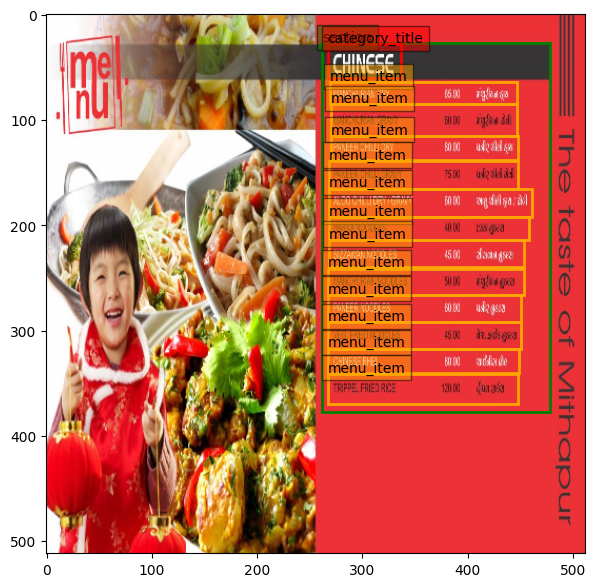

In [61]:
# Helper function to visualize bounding boxes
# It takes an image and a list of bounding boxes as inputs and plots an image with all the bounding boxes
# Each bounding box class should have a different color

color_map = {0: "red", 1: "orange", 2: "green"}


def visualize_bounding_boxes(plt, image, annotations, filter_classes=[]):
    plt.imshow(image)
    ax = plt.gca()

    for annotation in annotations:
        xmin, ymin, xmax, ymax, class_id = (
            annotation.xmin,
            annotation.ymin,
            annotation.xmax,
            annotation.ymax,
            annotation.class_id,
        )

        if len(filter_classes) > 0 and label_map[class_id] not in filter_classes:
            continue

        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor=color_map[class_id],
            linewidth=2,
        )
        ax.add_patch(rect)
        ax.text(
            xmin,
            ymin - 2,
            label_map[class_id],
            bbox=dict(facecolor=color_map[class_id], alpha=0.5),
        )


plt.figure(figsize=(7, 7))

visualize_bounding_boxes(plt, images[0], annotations[0])
plt.show()

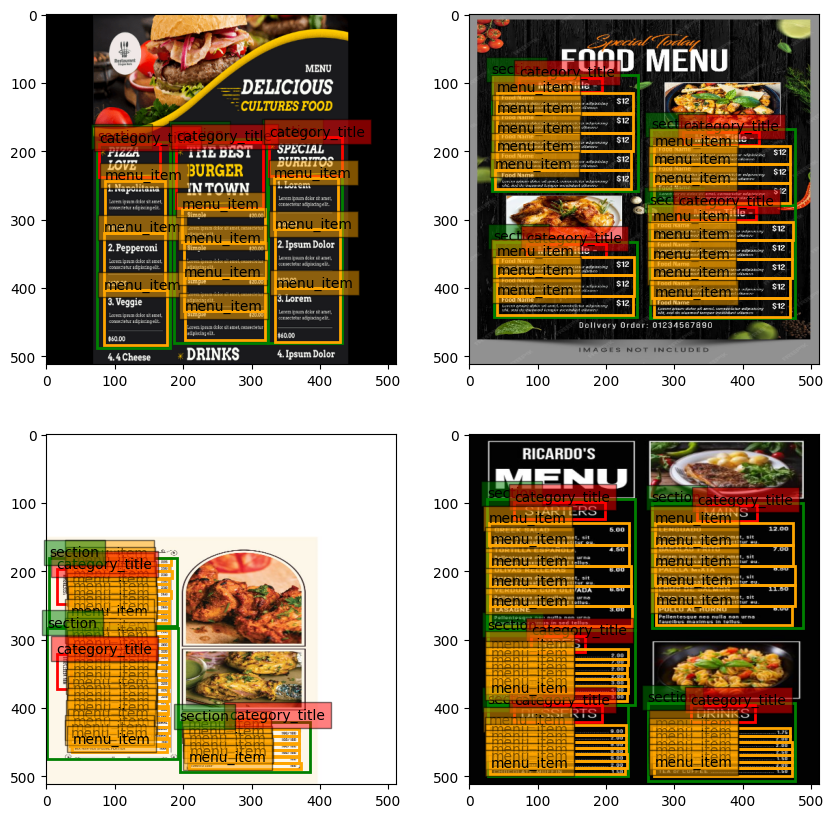

In [63]:
# Draw 4 randim images with bounding boxes in a 2x2 grid
plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    random_index = np.random.randint(len(images))
    visualize_bounding_boxes(plt, images[random_index], annotations[random_index])
plt.show()

In [54]:
def create_dir_or_clean(path):
    os.makedirs(path, exist_ok=True)
    for file in os.listdir(path):
        os.remove(os.path.join(path, file))

def save_images_and_txt_files(images, annotations, image_path, label_path, file_base_name):
    for i, (train_image, train_annotation) in enumerate(zip(images, annotations)):
        image_name = f'{file_base_name}_{i}.jpg'
        label_name = f'{file_base_name}_{i}.txt'

        # Write the image to disk using cv2. Keep in mind that the images are in RGB and cv2 uses BGR by default
        cv2.imwrite(os.path.join(image_path, image_name), cv2.cvtColor(train_image, cv2.COLOR_RGB2BGR))

        with open(os.path.join(label_path, label_name), 'w') as f:
            for annotation in train_annotation:
                f.write(f"{annotation[0]} {annotation[1]} {annotation[2]} {annotation[3]} {annotation[4]}\n")


In [55]:

# THis function has the following responsibilities:
# 1. Convert the annotations into the YOLO format
# 2. Split the data into train and validation sets
# 3. Save the data final_datasdet/images/train, final_datasdet/images/val and final_datasdet/labels/train, final_datasdet/labels/val
# 4. Save the label_map into final_datasdet/labels/darknet.labels
# 5. save the yolo configuration yaml file
def save_for_yolo_training(images, annotations):
    # Convert annotations into YOLO format
    yolo_annotations = []
    for sub_annotations in annotations:
        yolo_annotations.append([])
        for annotation in sub_annotations:
            x_center = (annotation.xmin + annotation.xmax) / 2
            y_center = (annotation.ymin + annotation.ymax) / 2
            width = annotation.xmax - annotation.xmin
            height = annotation.ymax - annotation.ymin

            # Normalize coordinates
            x_center /= input_shape[0]
            y_center /= input_shape[1]
            width /= input_shape[0]
            height /= input_shape[1]

            yolo_annotations[-1].append([annotation.class_id, x_center, y_center, width, height])

    # Split into train and validation sets
    train_images, val_images, train_annotations, val_annotations = train_test_split(images, yolo_annotations, test_size=0.2, shuffle=True, random_state=42)

    # Create the directories
    image_train_path = 'final_dataset/images/train'
    image_val_path = 'final_dataset/images/val'
    label_train_path = 'final_dataset/labels/train'
    label_val_path = 'final_dataset/labels/val'
    create_dir_or_clean(image_train_path)
    create_dir_or_clean(image_val_path)
    create_dir_or_clean(label_train_path)
    create_dir_or_clean(label_val_path)

    # Save the images and labels
    save_images_and_txt_files(train_images, train_annotations, image_train_path, label_train_path, 'train')
    save_images_and_txt_files(val_images, val_annotations, image_val_path, label_val_path, 'val')

    # Copy the darknet.labels file to label train and val paths
    os.system(f'cp {os.path.join(annotations_folder, "darknet.labels")} {label_train_path}')
    os.system(f'cp {os.path.join(annotations_folder, "darknet.labels")} {label_val_path}')

    # Create and save the yolo configuration file
    yolo_config = {
        'path': os.path.abspath('final_dataset'),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(label_map),
        'names': label_map,

    }
    yaml.dump(yolo_config, open('final_dataset/yolo_config.yaml', 'w'))


save_for_yolo_training(images, annotations)


In [11]:
class grid_search_result:
    def __init__(self, name, results, params, output_path):
        self.name = name
        self.results = results
        self.params = params
        self.output_path = output_path


    def __repr__(self):
        stringRepr = f'name: {self.name}\nresults: {self.results}\nparams: {self.params}\noutput_path: {self.output_path}'
        return stringRepr

In [12]:
from ultralytics import YOLO
from sklearn.model_selection import ParameterGrid
import uuid
from IPython.display import clear_output
import pickle
import pandas as pd

def get_persisted_state_path(persist_filename):
    if persist_filename is not None:
        return f"./{persist_filename}.pkl"
    return None

def load_persisted_state(persist_path):
    if os.path.exists(persist_path):
        with open(persist_path, 'rb') as f:
            return pickle.load(f)
    return None

def train_yolo_model(name, learning_rate, batch_size, num_epochs, netw_arch, confidence):
    model = YOLO(f"{netw_arch}.yaml").load(f"{netw_arch}.pt") # from local file

    results = model.train(data = "./final_dataset/yolo_config.yaml",lrf = learning_rate, epochs = num_epochs, batch = batch_size, name = name, conf = confidence)
    return model, results

def run_grid_search(learning_rates=[], batch_sizes=[], epochs=[], netw_archs=[], confidences=[], nms_thresholds=[], persist_state_filename=None):
    persist_path = None
    persisted_state = None
    if persist_state_filename is not None:
        persist_path = get_persisted_state_path(persist_state_filename)
        persisted_state = load_persisted_state(persist_path)

    if persisted_state is not None:
        print(f"Restoring persisted state from {persist_path}")

    pm_grid_space = persisted_state['pm_grid_space'] if persisted_state is not None else {'learning_rate': learning_rates,
                    'batch_size': batch_sizes,
                    'epochs': epochs,
                    'network_architecture': netw_archs,
                    'confidence': confidences}

    pm_grid = ParameterGrid(pm_grid_space)

    resultsList = persisted_state['resultsDict'] if persisted_state is not None else []

    index = persisted_state['index'] if persisted_state is not None else 0

    for index in range(index, len(pm_grid)):
        print(f"Training model {index+1}/{len(pm_grid)}........")

        name = "train-" + str(uuid.uuid4())
        params = pm_grid[index]
        learning_rate = params['learning_rate']
        batch_size = params['batch_size']
        num_epochs = params['epochs']
        netw_arch = params['network_architecture']
        confidence = params['confidence']
        #nms_thresh = params['NMS_threshold']

        print(f"Params:\nlearning_rate: {learning_rate}\nbatch_size: {batch_size}\nnum_epochs: {num_epochs}\nnetwork_architecture: {netw_arch}\nconfidence: {confidence}")

        model, results = train_yolo_model(name, learning_rate, batch_size, num_epochs, netw_arch, confidence)

        # Load csv from save_dir/results.csv into a dataframe
        csv_path = os.path.join(results.save_dir, 'results.csv')
        results_df = pd.read_csv(csv_path)
        results_df.rename(columns=lambda x: x.strip(), inplace=True)

        # Get the best epoch in terms of validation loss and put that row in a dictionary
        best_epoch = results_df.loc[results_df['val/box_loss'].idxmin()].to_dict()

        resultsList.append(grid_search_result(name, best_epoch, params, results.save_dir))

        index += 1

        if persist_path is not None:
            # Save pm_grid and index and resultsDict to file
            with open(persist_path, 'wb') as f:
                pickle.dump({'pm_grid_space': pm_grid_space, 'index': index, 'resultsDict': resultsList}, f)

        clear_output(wait=True)

    return resultsList


In [ ]:
# hyperparameters to search through
learning_rates = [0.1]
batch_sizes = [16,32]
epochs = [2,10]
netw_archs = ["yolov8m","yolov8x"]
confidences = [0.5,0.75]

resultsList = run_grid_search(learning_rates, batch_sizes, epochs, netw_archs, confidences, persist_state_filename='grid_search_state_1')
# resultsList


In [ ]:
# Load the persisted state
persisted_state = load_persisted_state(get_persisted_state_path('grid_search_state_1'))
print(persisted_state['resultsDict'])

[name: train-a7beba73-d565-4e4c-a825-ed5e52d59864
results: {'epoch': 2.0, 'train/box_loss': 2.9501, 'train/cls_loss': 3.317, 'train/dfl_loss': 2.3335, 'metrics/precision(B)': 0.03106, 'metrics/recall(B)': 0.22222, 'metrics/mAP50(B)': 0.02146, 'metrics/mAP50-95(B)': 0.00597, 'val/box_loss': 2.6333, 'val/cls_loss': 12.187, 'val/dfl_loss': 2.0131, 'lr/pg0': 7.0736e-05, 'lr/pg1': 7.0736e-05, 'lr/pg2': 7.0736e-05}
params: {'network_architecture': 'yolov8m', 'learning_rate': 0.1, 'epochs': 2, 'confidence': 0.5, 'batch_size': 16}
output_path: /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train-a7beba73-d565-4e4c-a825-ed5e52d59864]


In [13]:
def find_best_model(resultsDict, metric="metrics/mAP50(B)"):
    """
    Finds the best model in the resultsDict based on the metric
    :param resultsDict: list of grid_search_result objects
    :param metric: metric to compare the models with. Available metrics are: metrics/precision(B), metrics/recall(B), metrics/mAP50(B), metrics/mAP50-95(B)
    """
    best_model_results = None
    best_metric = -1
    for result in resultsDict:
        if result.results[metric] > best_metric:
            best_model_results = result
            best_metric = result.results[metric]

    return best_model_results




In [14]:
def print_best_models(resultsDict):
    best_model_results = find_best_model(resultsDict)
    print("mAP50\n", best_model_results)

    best_model_results = find_best_model(resultsDict, metric="metrics/mAP50-95(B)")
    print("\nmAP50-95\n", best_model_results)

    best_model_results = find_best_model(resultsDict, metric="metrics/precision(B)")
    print("\nprecision\n", best_model_results)

    best_model_results = find_best_model(resultsDict, metric="metrics/recall(B)")
    print("\nrecall\n", best_model_results)


In [ ]:
print_best_models(persisted_state['resultsDict'])

mAP50
 name: train-a7beba73-d565-4e4c-a825-ed5e52d59864
results: {'epoch': 2.0, 'train/box_loss': 2.9501, 'train/cls_loss': 3.317, 'train/dfl_loss': 2.3335, 'metrics/precision(B)': 0.03106, 'metrics/recall(B)': 0.22222, 'metrics/mAP50(B)': 0.02146, 'metrics/mAP50-95(B)': 0.00597, 'val/box_loss': 2.6333, 'val/cls_loss': 12.187, 'val/dfl_loss': 2.0131, 'lr/pg0': 7.0736e-05, 'lr/pg1': 7.0736e-05, 'lr/pg2': 7.0736e-05}
params: {'network_architecture': 'yolov8m', 'learning_rate': 0.1, 'epochs': 2, 'confidence': 0.5, 'batch_size': 16}
output_path: /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train-a7beba73-d565-4e4c-a825-ed5e52d59864

mAP50-95
 name: train-a7beba73-d565-4e4c-a825-ed5e52d59864
results: {'epoch': 2.0, 'train/box_loss': 2.9501, 'train/cls_loss': 3.317, 'train/dfl_loss': 2.3335, 'metrics/precision(B)': 0.03106, 'metrics/recall(B)': 0.22222, 'metrics/mAP50(B)': 0.02146, 'metrics/mAP50-95(B)': 0.00597, 'val/box_loss': 2.6333, 'val/cls_loss': 12.187, 'val/dfl

In [ ]:
# hyperparameters to search through
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16]
epochs = [10, 16]
netw_archs = ["yolov8x"]
confidences = [0.5,0.7,0.9]

# resultsList = run_grid_search(learning_rates, batch_sizes, epochs, netw_archs, confidences, persist_state_filename='grid_search_state_2')
# resultsList


In [17]:
persisted_state_2 = load_persisted_state(get_persisted_state_path('grid_search_state_2'))
print_best_models(persisted_state_2['resultsDict'])


mAP50
 name: train-157fccdf-e2ca-4833-981c-5230bfaf9f6c
results: {'metrics/precision(B)': 0.6245094594781945, 'metrics/recall(B)': 0.7231556735416241, 'metrics/mAP50(B)': 0.6914025988269916, 'metrics/mAP50-95(B)': 0.42429682015011594, 'fitness': 0.45100739801780354}
params: {'network_architecture': 'yolov8x', 'learning_rate': 0.001, 'epochs': 16, 'confidence': 0.5, 'batch_size': 16}
output_path: runs/detect/train-157fccdf-e2ca-4833-981c-5230bfaf9f6c

mAP50-95
 name: train-b5af3341-55c7-4a59-b6f4-a8ef7e589843
results: {'metrics/precision(B)': 0.6223424147155784, 'metrics/recall(B)': 0.7241596896058812, 'metrics/mAP50(B)': 0.6874067476425977, 'metrics/mAP50-95(B)': 0.4309731943934668, 'fitness': 0.4566165497183799}
params: {'network_architecture': 'yolov8x', 'learning_rate': 0.001, 'epochs': 16, 'confidence': 0.7, 'batch_size': 16}
output_path: runs/detect/train-b5af3341-55c7-4a59-b6f4-a8ef7e589843

precision
 name: train-157fccdf-e2ca-4833-981c-5230bfaf9f6c
results: {'metrics/precision(

In [ ]:
# hyperparameters to search through
# learning_rates = [0.0005, 0.001, 0.005]
# batch_sizes = [16]
# epochs = [16]
# netw_archs = ["yolov8x"]
# confidences = [0.5,0,6,0.7,0.8]

# resultsList = run_grid_search(learning_rates, batch_sizes, epochs, netw_archs, confidences, persist_state_filename='grid_search_state_3')


In [ ]:
# persisted_state_3 = load_persisted_state(get_persisted_state_path('grid_search_state_3'))
# print_best_models(persisted_state_3['resultsDict'])

In [18]:
# Train the best model on the entire dataset
best_model_results = find_best_model(persisted_state_2['resultsDict'], metric="metrics/mAP50(B)")
best_params = best_model_results.params

model, results = train_yolo_model("best_model", best_params['learning_rate'], best_params['batch_size'], best_params['epochs'], best_params['network_architecture'], best_params['confidence'])


                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640

100%|██████████| 755k/755k [00:00<00:00, 18.1MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              


  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 6.23M/6.23M [00:00<00:00, 132MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/final_dataset/labels/train... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 1689.36it/s]

train: New cache created: /content/final_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/final_dataset/labels/val... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<00:00, 874.68it/s]

val: New cache created: /content/final_dataset/labels/val.cache


Plotting labels to runs/detect/best_model2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
16 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/16      12.9G      2.842      4.022      2.423        264        640: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all         18        427      0.111    0.00641     0.0566      0.034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/16      13.7G      2.751      3.385       2.21        199        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         18        427     0.0857      0.182     0.0561     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/16      13.9G      2.172      2.278      1.731        216        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         18        427      0.194      0.367      0.174     0.0966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/16      13.6G      1.933      1.717       1.54        323        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         18        427      0.234      0.444      0.236      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/16      13.6G      1.795      1.568      1.473        132        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         18        427       0.29      0.345      0.219      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/16      13.8G      1.668      1.376       1.42        271        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         18        427      0.276       0.62      0.318      0.161


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/16        14G      1.711      1.474      1.432        162        640: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         18        427       0.25      0.544      0.298      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/16        14G      1.682      1.428      1.411        123        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         18        427      0.206      0.651      0.288       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/16      14.1G      1.674      1.404       1.42         95        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         18        427      0.388      0.436      0.283      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/16        14G      1.643      1.419      1.369        180        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         18        427       0.31      0.259      0.249      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/16        14G      1.556      1.265      1.366        160        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         18        427      0.217      0.601      0.267      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/16        14G      1.571      1.203      1.303        137        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         18        427      0.302      0.609      0.321       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/16        14G      1.464      1.104      1.286        147        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         18        427      0.348      0.537      0.416      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/16      14.1G      1.436      1.151      1.286        197        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         18        427      0.446      0.571      0.498       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/16      14.1G      1.402      1.081      1.275        135        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         18        427      0.504      0.656      0.598      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/16        14G      1.367     0.9921      1.228        133        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         18        427      0.566      0.644      0.626      0.367



16 epochs completed in 0.073 hours.
Optimizer stripped from runs/detect/best_model2/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/best_model2/weights/best.pt, 136.7MB

Validating runs/detect/best_model2/weights/best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


                   all         18        427      0.566      0.644      0.624      0.366
        category_title         18         45      0.662      0.392      0.548      0.285
             menu_item         18        330      0.643      0.733      0.713      0.389
               section         18         52      0.395      0.808      0.611      0.424
Speed: 0.2ms preprocess, 29.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/best_model2


In [ ]:
# Load the best model from the disk
model = YOLO("yolov8x.yaml").load(os.path.join("/home/lukas/Uni/Fontys/Semester7/DASC2/dasc2-data-challenge-project/Menu_Card_Transformation/best.pt"))



                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           


  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

In [64]:
def predict_img_plot_bounding_boxes(plt, image, filter_classes=[]):
    results = model.predict(image)
    bounding_boxes = []

    boxes = results[0].boxes
    for box in boxes:
        box_coords = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format

        class_id = box.cls  # class_id is:  tensor([2.], device='cuda:0')
        # Get as int
        class_id = int(class_id[0])

        classname = model.names[int(class_id)]
        if len(filter_classes) > 0 and classname not in filter_classes:
            continue

        bounding_boxes.append(
            BoundingBox(
                int(box_coords[0]),
                int(box_coords[1]),
                int(box_coords[2]),
                int(box_coords[3]),
                class_id,
                "",
            )
        )

    visualize_bounding_boxes(plt, image, bounding_boxes, filter_classes)


0: 640x640 14 category_titles, 29 menu_items, 6 sections, 97.4ms
Speed: 4.4ms preprocess, 97.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 105 menu_items, 22 sections, 81.5ms
Speed: 4.3ms preprocess, 81.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 category_titles, 24 menu_items, 11 sections, 80.0ms
Speed: 4.0ms preprocess, 80.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 category_titles, 43 menu_items, 7 sections, 79.9ms
Speed: 4.2ms preprocess, 79.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


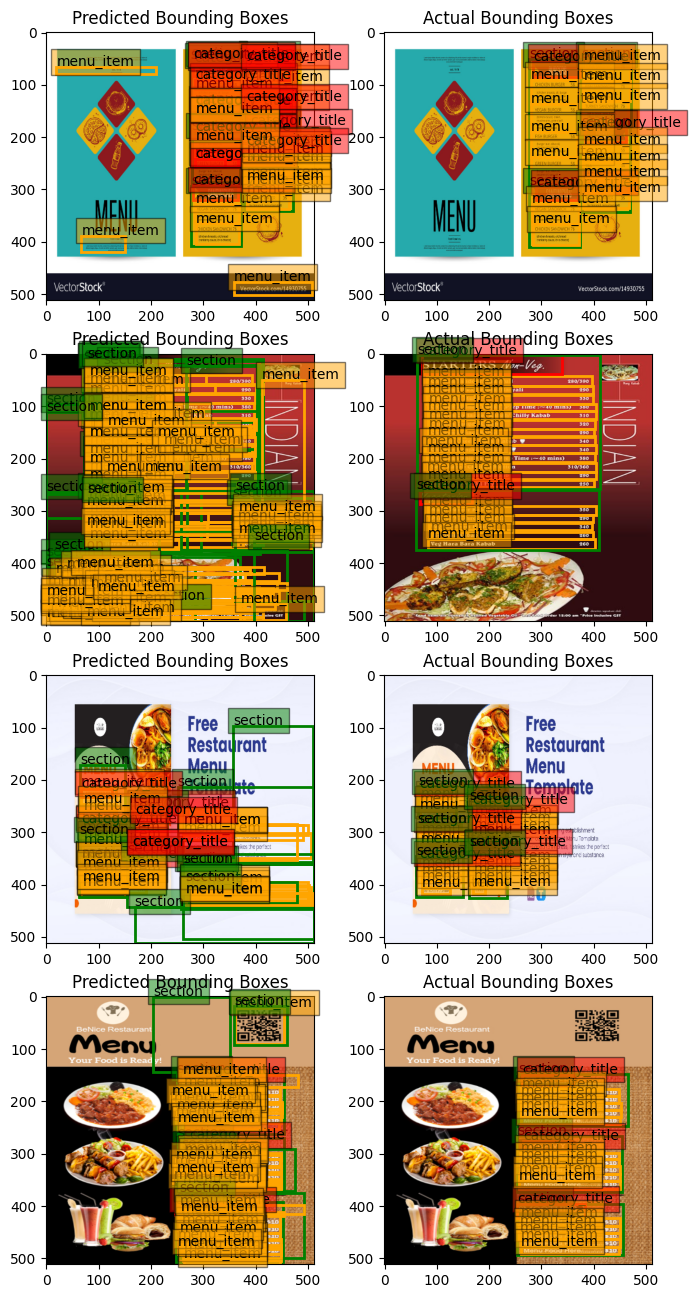

In [65]:
plt.figure(figsize=(8, 16))
# Take some random images from the dataset and run the model on them
random_indices = np.random.randint(len(images), size=4)
for idx, random_index in enumerate(random_indices ,start=1):
    img = images[random_index]
    # Plot the image with bounding boxes
    plt.subplot(4, 2, 2 * idx - 1)
    predict_img_plot_bounding_boxes(plt, img)
    plt.title('Predicted Bounding Boxes')

    # Plot the actual bounding boxes
    plt.subplot(4, 2, 2 * idx)
    visualize_bounding_boxes(plt, img,annotations[random_index])
    plt.title('Actual Bounding Boxes')

plt.show()


0: 640x640 8 category_titles, 58 menu_items, 17 sections, 97.0ms
Speed: 3.8ms preprocess, 97.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 14 category_titles, 99 menu_items, 25 sections, 81.3ms
Speed: 3.3ms preprocess, 81.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 category_titles, 116 menu_items, 12 sections, 79.7ms
Speed: 3.6ms preprocess, 79.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 category_titles, 49 menu_items, 6 sections, 79.7ms
Speed: 3.7ms preprocess, 79.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


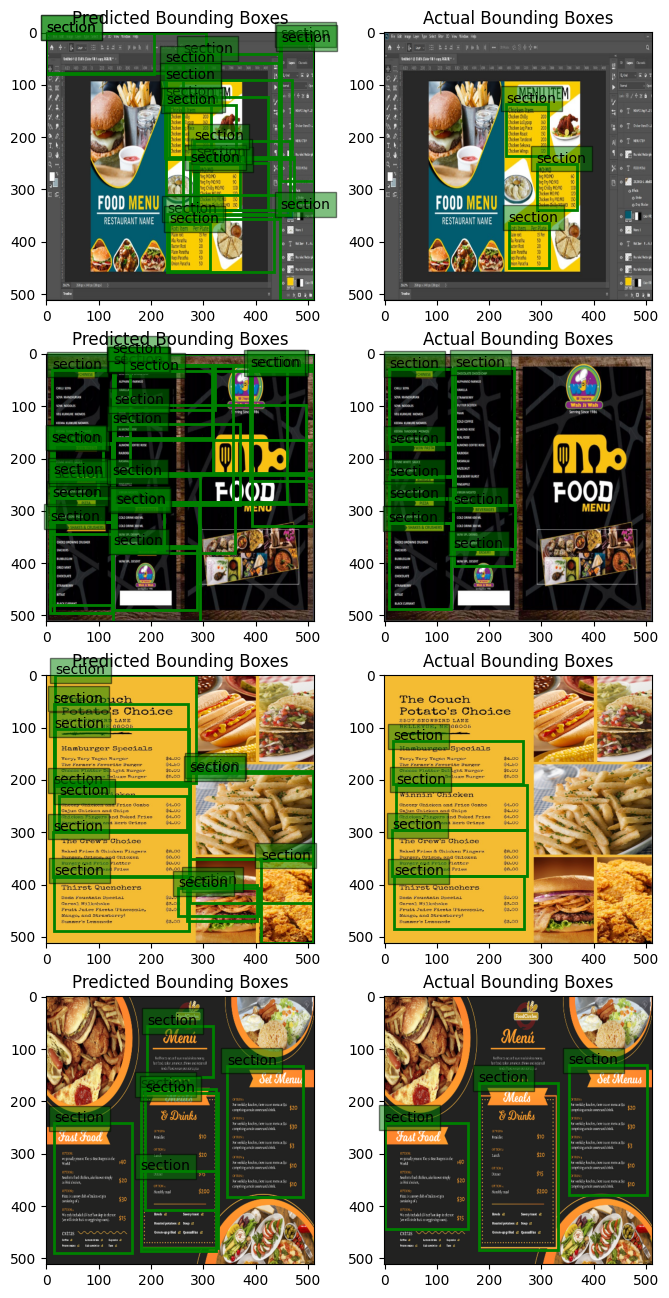

In [66]:
plt.figure(figsize=(8, 16))
# Take some random images from the dataset and run the model on them
random_indices = np.random.randint(len(images), size=4)
for idx, random_index in enumerate(random_indices, start=1):
    img = images[random_index]
    # Plot the image with bounding boxes
    plt.subplot(4, 2, 2 * idx - 1)
    predict_img_plot_bounding_boxes(plt, img, ["section"])
    plt.title("Predicted Bounding Boxes")

    # Plot the actual bounding boxes
    plt.subplot(4, 2, 2 * idx)
    visualize_bounding_boxes(plt, img, annotations[random_index], ["section"])
    plt.title("Actual Bounding Boxes")

plt.show()


0: 640x640 1 category_title, 28 menu_items, 3 sections, 97.0ms
Speed: 4.0ms preprocess, 97.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 category_titles, 27 menu_items, 10 sections, 94.1ms
Speed: 5.9ms preprocess, 94.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 category_title, 11 menu_items, 7 sections, 62.3ms
Speed: 4.7ms preprocess, 62.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 category_titles, 52 menu_items, 9 sections, 59.7ms
Speed: 4.1ms preprocess, 59.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


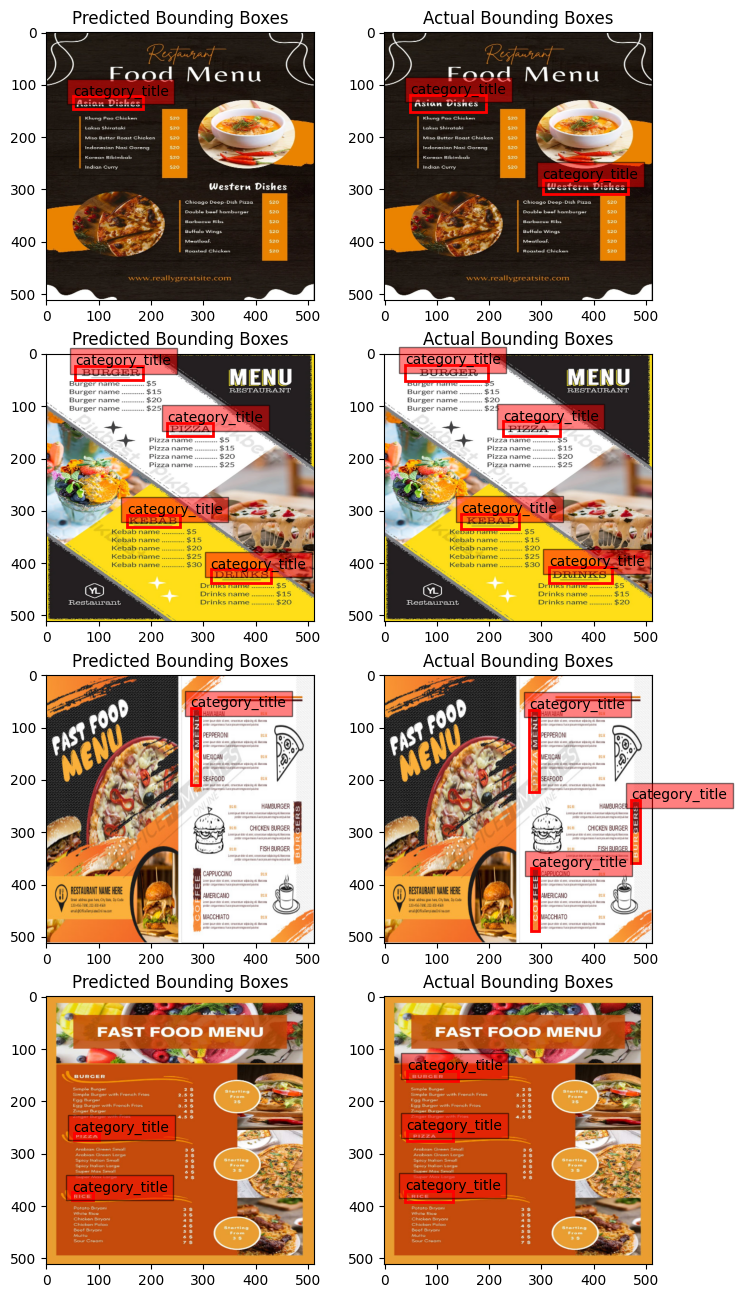

In [67]:
plt.figure(figsize=(8, 16))
# Take some random images from the dataset and run the model on them
random_indices = np.random.randint(len(images), size=4)
for idx, random_index in enumerate(random_indices, start=1):
    img = images[random_index]
    # Plot the image with bounding boxes
    plt.subplot(4, 2, 2 * idx - 1)
    predict_img_plot_bounding_boxes(plt, img, ["category_title"])
    plt.title("Predicted Bounding Boxes")

    # Plot the actual bounding boxes
    plt.subplot(4, 2, 2 * idx)
    visualize_bounding_boxes(plt, img, annotations[random_index], ["category_title"])
    plt.title("Actual Bounding Boxes")

plt.show()


0: 640x640 55 menu_items, 10 sections, 97.4ms
Speed: 4.0ms preprocess, 97.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 category_titles, 28 menu_items, 6 sections, 87.6ms
Speed: 5.1ms preprocess, 87.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 category_titles, 66 menu_items, 7 sections, 83.4ms
Speed: 4.1ms preprocess, 83.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 category_titles, 33 menu_items, 9 sections, 70.7ms
Speed: 4.0ms preprocess, 70.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


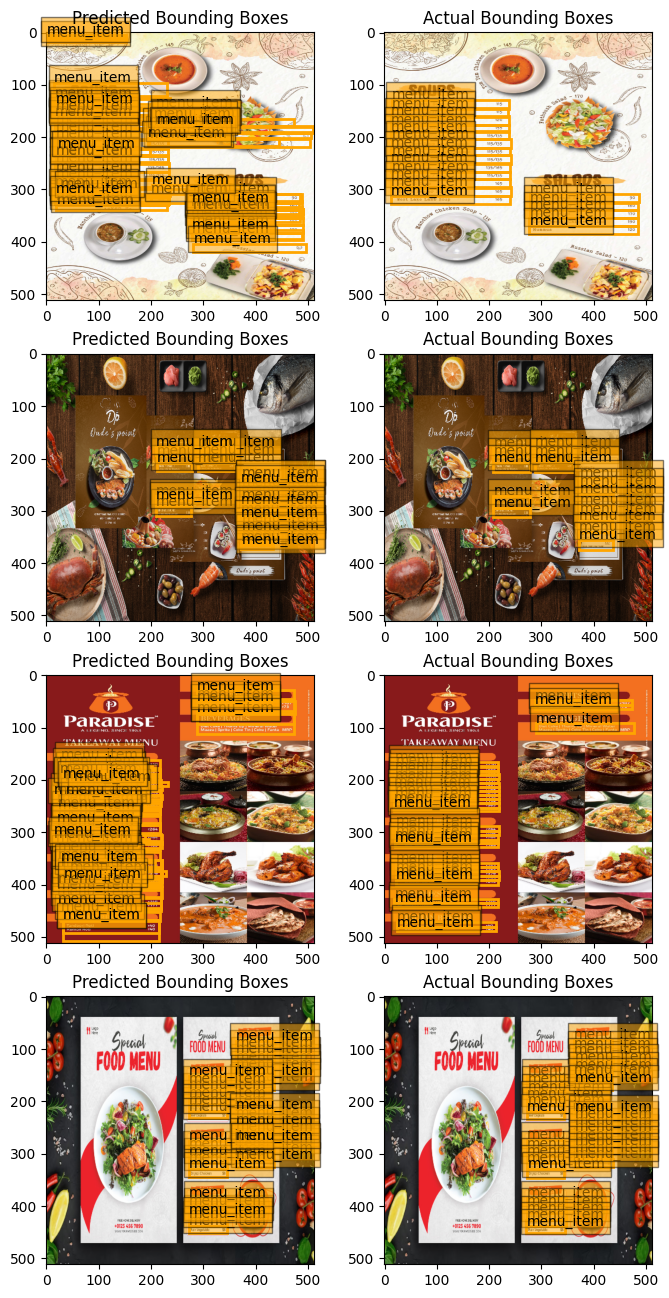

In [68]:
plt.figure(figsize=(8, 16))
# Take some random images from the dataset and run the model on them
random_indices = np.random.randint(len(images), size=4)
for idx, random_index in enumerate(random_indices, start=1):
    img = images[random_index]
    # Plot the image with bounding boxes
    plt.subplot(4, 2, 2 * idx - 1)
    predict_img_plot_bounding_boxes(plt, img, ["menu_item"])
    plt.title("Predicted Bounding Boxes")

    # Plot the actual bounding boxes
    plt.subplot(4, 2, 2 * idx)
    visualize_bounding_boxes(plt, img, annotations[random_index], ["menu_item"])
    plt.title("Actual Bounding Boxes")

plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import shutil

# # Define the source directory and the destination directory
# source_dir = '/content/runs'
# destination_dir = '/content/drive/MyDrive/Fontys/SEMESTER_7/DASC2/Model'

# # Copy the directory
# shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)